In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'  #선명하게 만들기
# 한글 문제
# matplotlib의 기본 폰트에서 한글이 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

    
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"
import pandas as pd
train_data = pd.read_csv('../DATA/train.csv',encoding='cp949')
test_data = pd.read_csv('../DATA/test.csv',encoding='cp949')

# 파일 다운로드 경로를 미리 설정해두면 이름만 써도 됨


In [117]:
train_data.info()
# 열이름 한눈에 알아보기 쉽게 재설정
train_data.rename(columns={'Date':'날짜', 'Rented Bike Count':'대여횟수', 'Hour':'시', 'Temperature(吏퇒)':'온도', 'Humidity(%)':'습도',
       'Wind speed (m/s)':'풍속', 'Visibility (10m)':'가시성', 'Dew point temperature(吏퇒)':'이슬점',
       'Solar Radiation (MJ/m2)':'태양 복사에너지', 'Rainfall(mm)':'강수량', 'Snowfall (cm)':'강설량', 'Seasons':'계절',
       'Holiday':'휴무일여부', 'Functioning Day':'작동여부'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8040 non-null   object 
 1   Rented Bike Count          8040 non-null   int64  
 2   Hour                       8040 non-null   int64  
 3   Temperature(吏퇒)            7240 non-null   float64
 4   Humidity(%)                8040 non-null   int64  
 5   Wind speed (m/s)           7238 non-null   float64
 6   Visibility (10m)           8040 non-null   int64  
 7   Dew point temperature(吏퇒)  8040 non-null   float64
 8   Solar Radiation (MJ/m2)    8040 non-null   float64
 9   Rainfall(mm)               8040 non-null   float64
 10  Snowfall (cm)              8040 non-null   float64
 11  Seasons                    7238 non-null   object 
 12  Holiday                    8040 non-null   object 
 13  Functioning Day            8040 non-null   objec

## 1차 전처리- 결측치 , 이상치 처리

In [119]:
train_data.isna().sum()
train_data[train_data.duplicated()]

날짜            0
대여횟수          0
시             0
온도          800
습도            0
풍속          802
가시성           0
이슬점           0
태양 복사에너지      0
강수량           0
강설량           0
계절          802
휴무일여부         0
작동여부          0
dtype: int64

,날짜,대여횟수,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부


In [120]:
train_data['날짜']=pd.to_datetime(train_data['날짜'], format='%d/%m/%Y')

In [121]:
train_data['날짜'].describe()

count                   8040
mean     2018-05-17 00:00:00
min      2017-12-01 00:00:00
25%      2018-02-22 00:00:00
50%      2018-05-17 00:00:00
75%      2018-08-09 00:00:00
max      2018-10-31 00:00:00
Name: 날짜, dtype: object

In [123]:
# 계절 전처리 
# 1. date 타입으로 날짜 형식 변환
train_data['날짜']=pd.to_datetime(train_data['날짜'], format='%d/%m/%Y')

# 2. 입춘 입하 입추 입동 기준으로 처리
# 날짜 구간 나누기
winter_df= (train_data['날짜'] >= '2017-11-07') & (train_data['날짜'] < '2018-02-04')
spring_df = (train_data['날짜'] >= '2018-02-04') & (train_data['날짜'] < '2018-05-05')
summer_df = (train_data['날짜'] >= '2018-05-05') & (train_data['날짜'] < '2018-08-07')
autumn_df = (train_data['날짜'] >= '2018-08-07') & (train_data['날짜'] < '2018-11-07')

# 조건문으로 빈 값 채우기
if (winter_df).any():
    train_data['계절'].fillna('Winter', inplace=True)
elif (spring_df).any():
    train_data['계절'].fillna('Spring', inplace=True)
elif (summer_df).any():
    train_data['계절'].fillna('Summer', inplace=True)
elif (autumn_df).any():
    train_data['계절'].fillna('Autumn', inplace=True)

In [124]:
train_data['계절'].isna().sum()
train_data.isnull().sum()

0

날짜            0
대여횟수          0
시             0
온도          800
습도            0
풍속          802
가시성           0
이슬점           0
태양 복사에너지      0
강수량           0
강설량           0
계절            0
휴무일여부         0
작동여부          0
dtype: int64

In [125]:
# 온도 결측치 처리
# 계절 평균온도로 결측치 처리해주기 
df_tem=train_data.copy()

In [126]:
tem_season_df=pd.DataFrame(train_data.groupby(['계절'])['온도'].mean())
x=tem_season_df.values.flatten().tolist()
if (train_data['계절']=='Autumn').any():
    df_tem['온도'].fillna(round(x[0],2), inplace=True)
elif (train_data['계절']=='Spring').any():
    df_tem['온도'].fillna(round(x[1],2), inplace=True)
elif (train_data['계절']=='Summer').any():
    df_tem['온도'].fillna(round(x[2],2), inplace=True)
elif (train_data['계절']=='Winter').any():
    df_tem['온도'].fillna(round(x[3],2), inplace=True)

In [127]:
df_tem['온도'].isnull().sum()
df_tem.isnull().sum()

0

날짜            0
대여횟수          0
시             0
온도            0
습도            0
풍속          802
가시성           0
이슬점           0
태양 복사에너지      0
강수량           0
강설량           0
계절            0
휴무일여부         0
작동여부          0
dtype: int64

<Axes: >

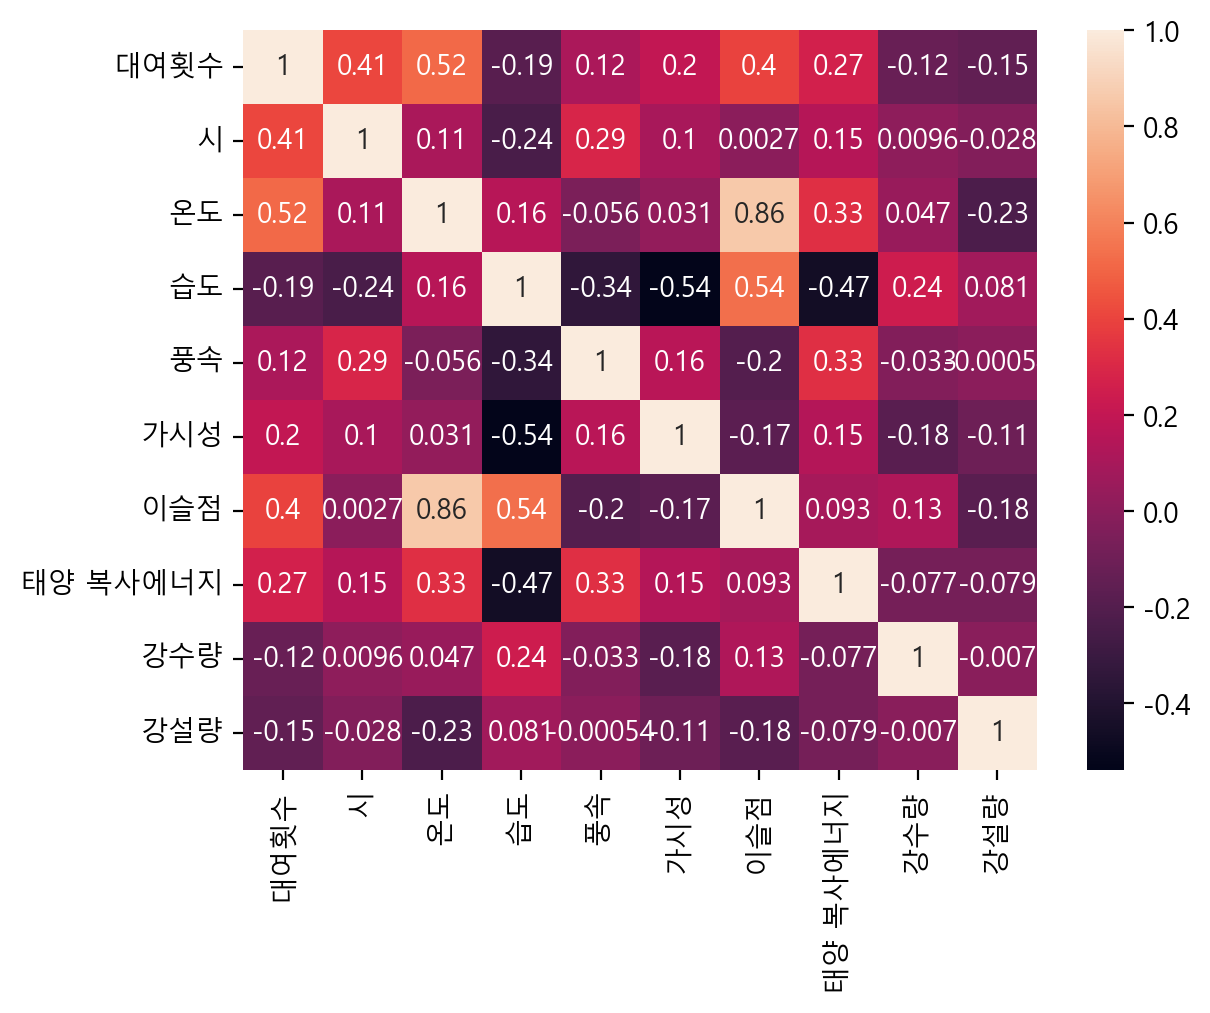

In [128]:
# 풍속 결측치 처리
# 다중 대체로 처리하기
from fancyimpute import IterativeImputer
df_num=df_tem._get_numeric_data()
sns.heatmap(df_num.corr(),annot=True)
# 풍속과 대양 복사에너지, 시간, 습도 상관관계를 볼 수 있음 

In [129]:
imputer = IterativeImputer()
imputed_arr=imputer.fit_transform(train_data[['풍속', '태양 복사에너지', '시','습도']])
df_tem.풍속=pd.DataFrame(imputed_arr, columns=['풍속', '태양 복사에너지', '시','습도']).풍속

In [130]:
imputed_arr

array([[ 2.2,  0. ,  0. , 37. ],
       [ 0.8,  0. ,  1. , 38. ],
       [ 1. ,  0. ,  2. , 39. ],
       ...,
       [ 3. ,  0. , 21. , 59. ],
       [ 2.2,  0. , 22. , 58. ],
       [ 1.8,  0. , 23. , 60. ]])

In [131]:
df_tem.isnull().sum()

날짜          0
대여횟수        0
시           0
온도          0
습도          0
풍속          0
가시성         0
이슬점         0
태양 복사에너지    0
강수량         0
강설량         0
계절          0
휴무일여부       0
작동여부        0
dtype: int64

In [132]:
df_tem['풍속']

0       2.200000
1       0.800000
2       1.000000
3       0.900000
4       1.599755
          ...   
8035    1.904459
8036    0.700000
8037    3.000000
8038    2.200000
8039    1.800000
Name: 풍속, Length: 8040, dtype: float64

In [133]:
train_data=df_tem

### 이상치
- linear regression (선형회귀)란 
- 독립 변수들과 종속 변수 간의 관계를 예측할 떄, 그 사이 관계를 선형으로 가정하고 모델링하는 것으로 예측에 주로 사용됨
- 독립변수에 영향을 줄 수 있는 종속 변수가 일반적인 값 보다 편차가 상대적으로 커서 동떨어져 있는 경우 독립변수 예측에 큰 영향을 미칠 수 있기 때문에 반드시 처리해줘야한다. 

C:\Users\minye\AppData\Local\Temp\ipykernel_12808\928609544.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data[['대여횟수']], fit=stats.norm)


<Axes: ylabel='Density'>

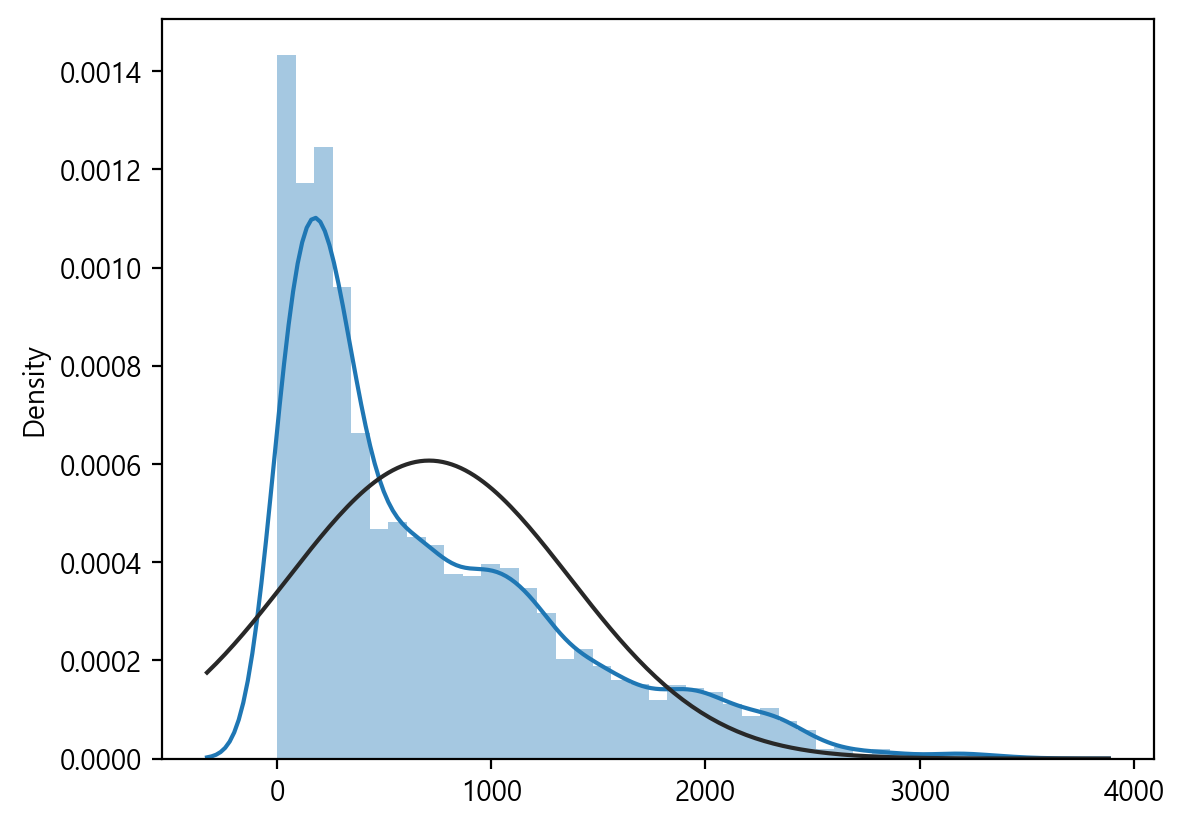

<Axes: >

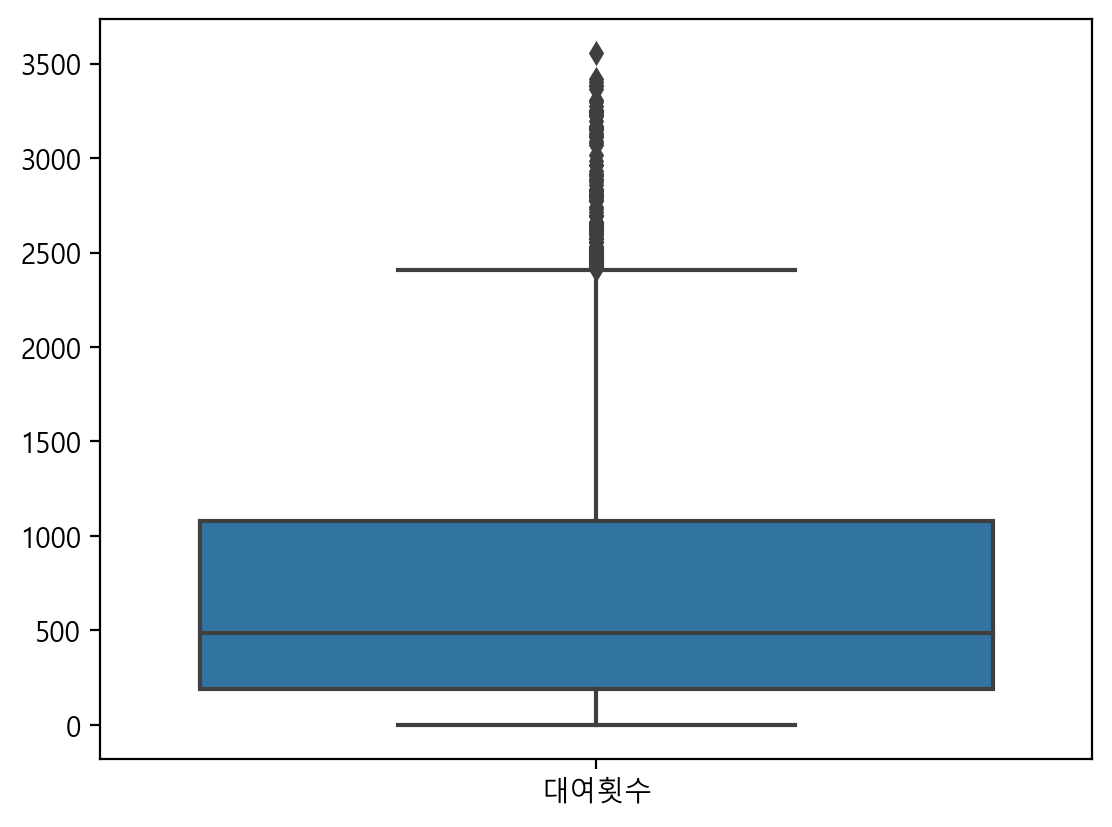

In [135]:
# 제일 먼저 target 값이 될 대여횟수의 분포를 확인하고 이상치 확인 

sns.distplot(train_data[['대여횟수']], fit=stats.norm)

# 이상치 확인 
plt.show()

sns.boxplot(train_data[['대여횟수']])
# 동떨어진 값은 없는거 같다.

In [136]:
train_data[train_data['대여횟수']==0]['작동여부'].unique()
# 작동하지 않은 날에 대여횟수가 No이기 때문에 대여횟수 0인 것은 선형 회귀 모델에 있어서 의미 있는 데이터가 아니다.
# 그러므로 삭제하는 것이 좋음
train_data_del= train_data.drop(train_data[train_data['대여횟수']==0].index,axis=0)

array(['No'], dtype=object)

In [137]:
train_data.shape

(8040, 14)

In [138]:
# 이상치 처리 
train_data_del.head()
train_data_del.shape

,날짜,대여횟수,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부
0,2017-12-01,254,0,-5.2,37,2.200000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.800000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.900000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,1.599755,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


(7817, 14)

In [140]:
x_df = train_data_del.select_dtypes(include=['object']).columns
new_df = train_data_del.drop(columns=x_df)
new_df.shape

(7817, 11)

<Axes: >

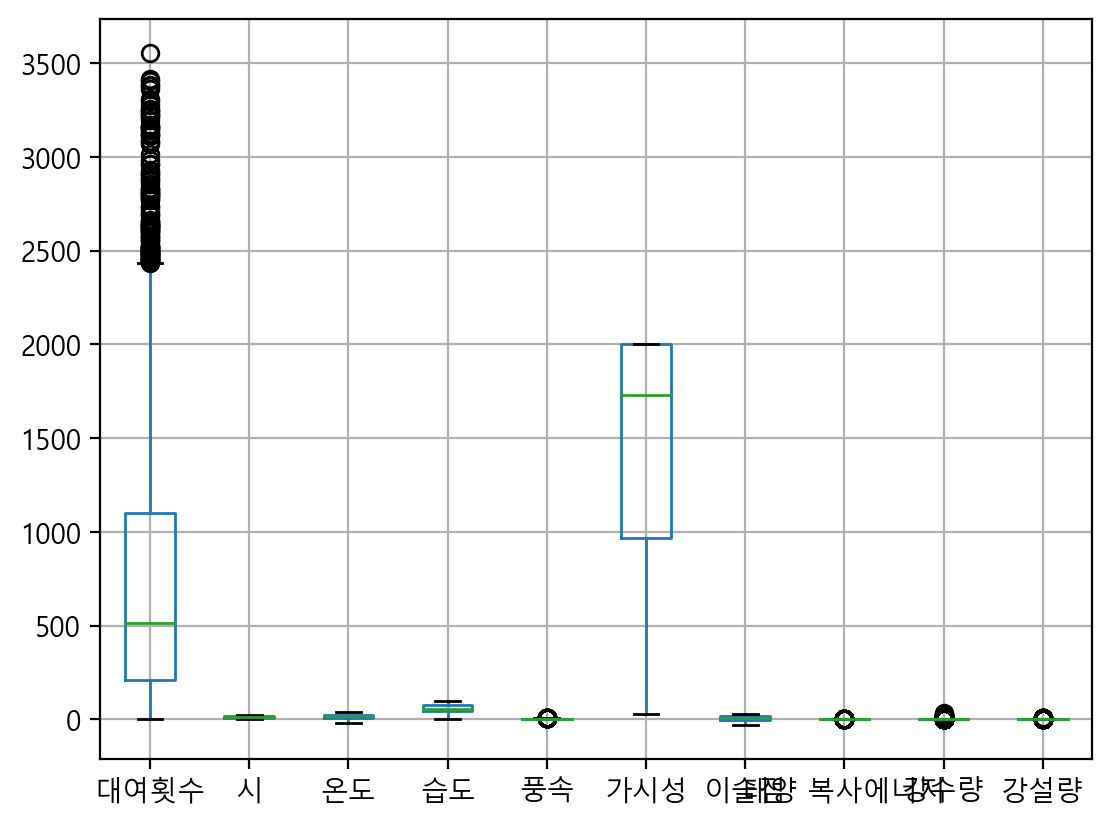

<Axes: >

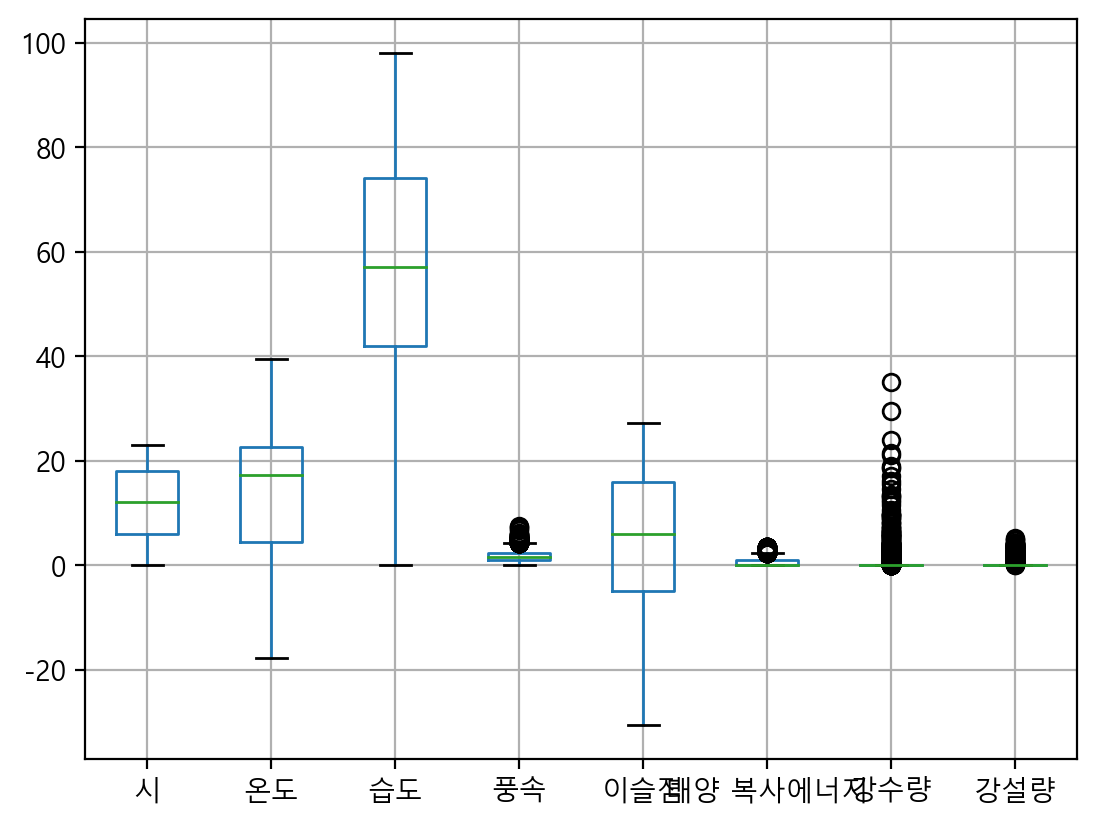

<Axes: >

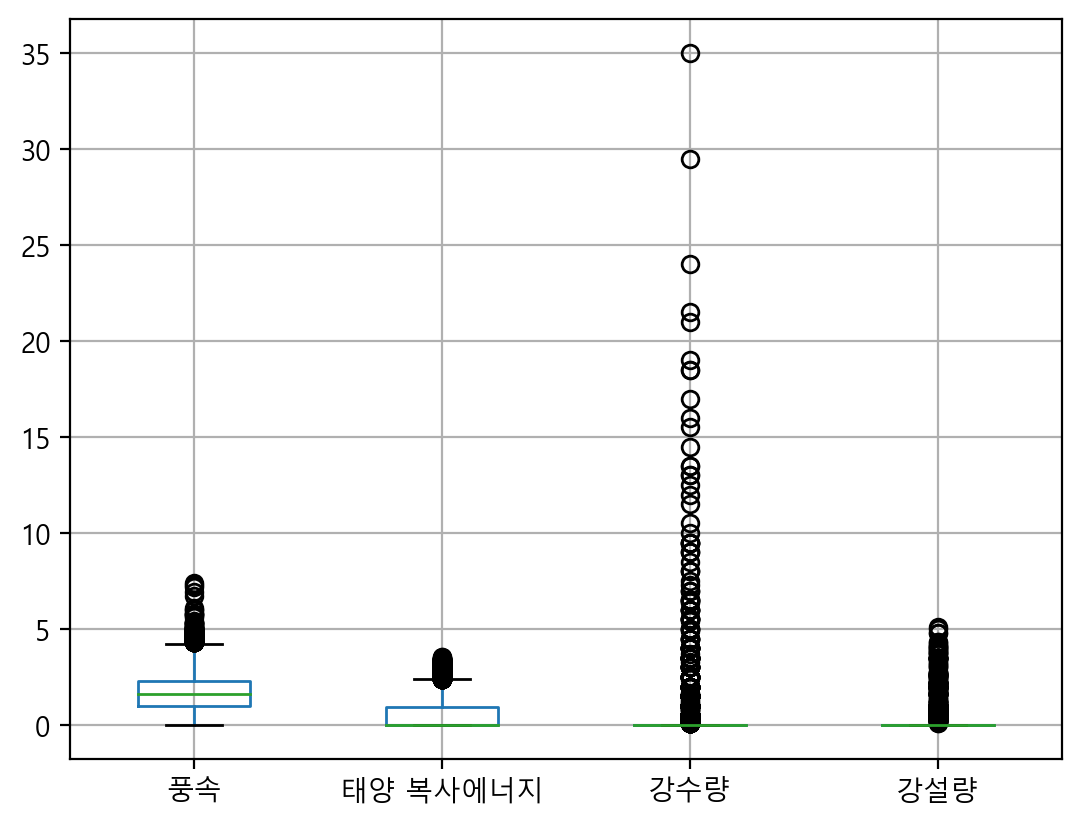

In [141]:
new_df.boxplot()
plt.show()
new_df.drop(['대여횟수','가시성'] , axis=1).boxplot()
plt.show()
# 이상치가 보이는 네 가지 피처 확인해봄 
new_df[['풍속','태양 복사에너지','강수량','강설량']].boxplot()

<Figure size 1500x1000 with 0 Axes>

<Axes: >

<Axes: xlabel='시', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='온도', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='습도', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='풍속', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='가시성', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='이슬점', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='태양 복사에너지', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='강수량', ylabel='대여횟수'>

<Axes: >

<Axes: xlabel='강설량', ylabel='대여횟수'>

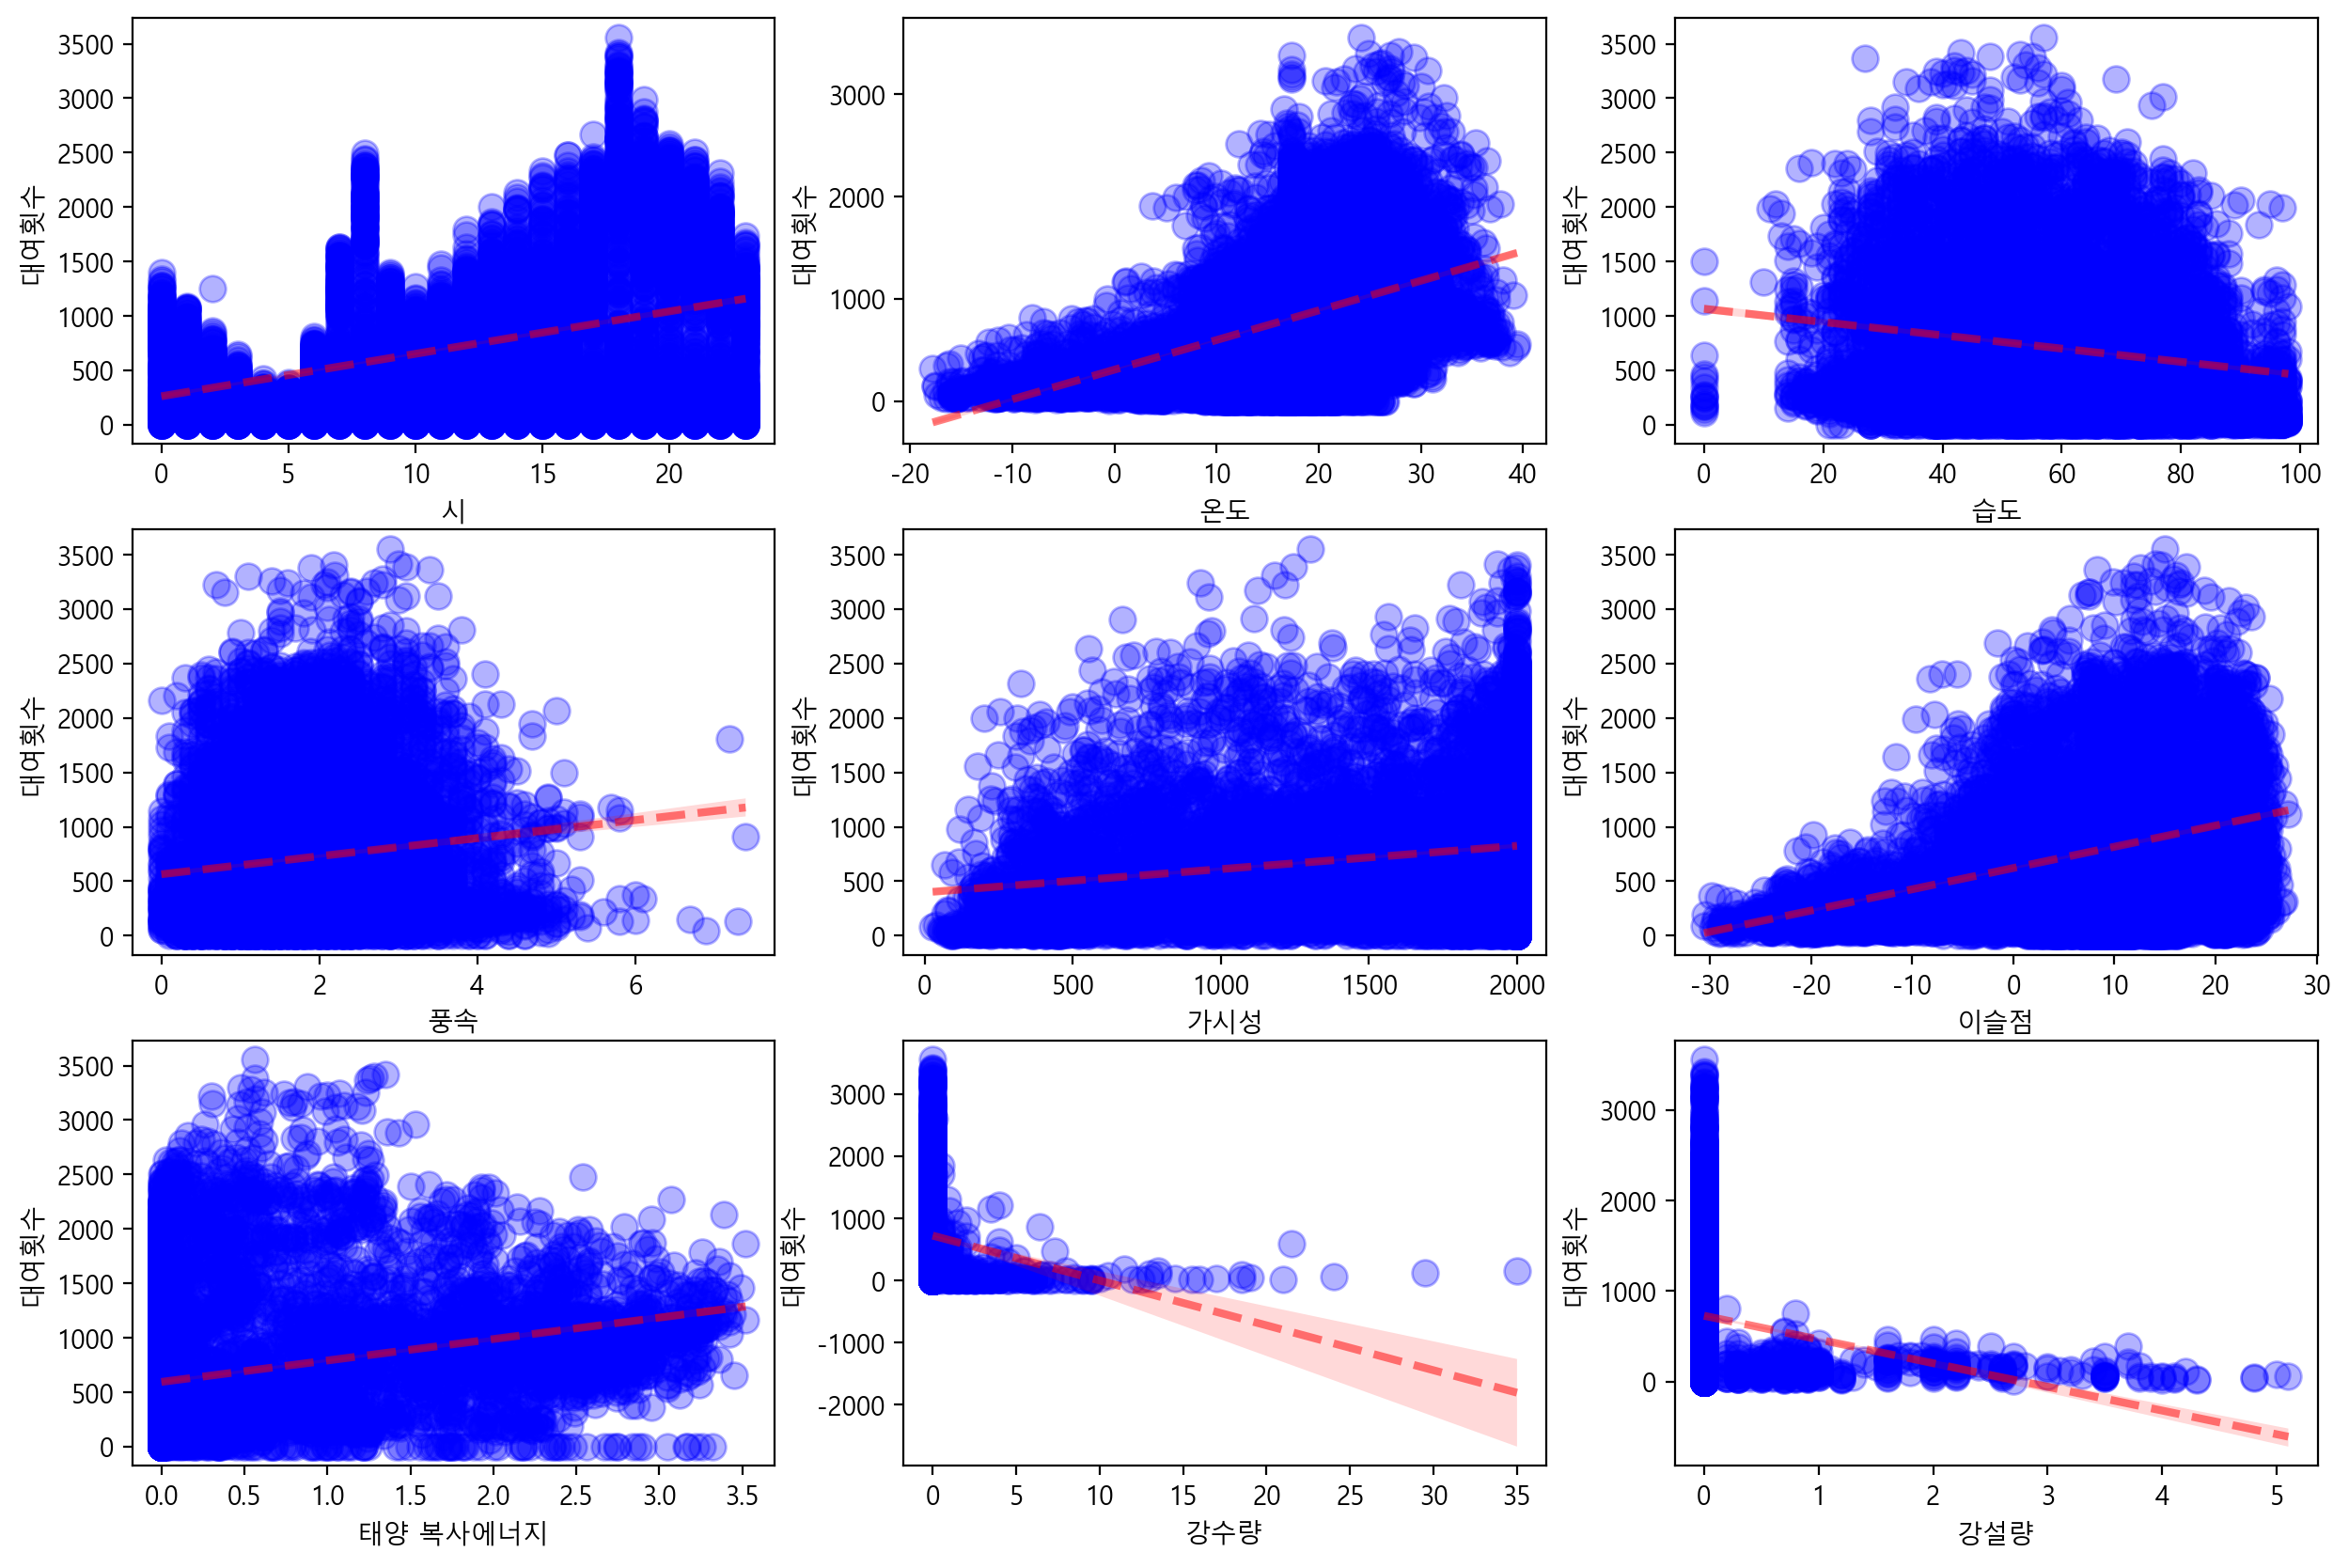

In [142]:
# 선형 회귀 모델을 사용할 것인 만큼
# target 인 대여횟수와 종속변수와의 관계를 확인해볼 필요가 있다. 
# regplot을 통해 산점도 및 회귀선을 확인할 수 있다. 

features= ['시','온도','습도','풍속','가시성','이슬점','태양 복사에너지','강수량','강설량']
plt.figure(figsize=(15,10))
for i , features in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.regplot(x=features, y='대여횟수', data=train_data,scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
    
plt.show()

In [143]:
new_df.corr().iloc[:,1:2].sort_values(by='대여횟수', ascending=False)
# 날짜, 시간, 온도, 이슬점과 상관관계를 보인다.
# - 선형회귀 모델을 사용할 때 주의 깊게 봐야 할 변수들이라고 할 수 있다.
# 네 가지 변수의 이상치를 주로 처리하겠다. 

,대여횟수
대여횟수,1.000000
온도,0.535766
날짜,0.461632
시,0.422578
이슬점,0.415696
태양 복사에너지,0.276966
가시성,0.216402
풍속,0.128480
강수량,-0.128288
강설량,-0.158770


In [144]:
new_df[['날짜','시','온도','이슬점']].describe()

,날짜,시,온도,이슬점
count,7817,7817.000000,7817.000000,7817.000000
mean,2018-05-14 02:42:17.546373120,11.507612,13.777627,4.404158
min,2017-12-01 00:00:00,0.000000,-17.800000,-30.600000
25%,2018-02-20 00:00:00,6.000000,4.400000,-5.000000
50%,2018-05-14 00:00:00,12.000000,17.290000,6.000000
75%,2018-08-04 00:00:00,18.000000,22.600000,15.800000
max,2018-10-31 00:00:00,23.000000,39.400000,27.200000
std,NaN,6.920792,11.831578,13.544424


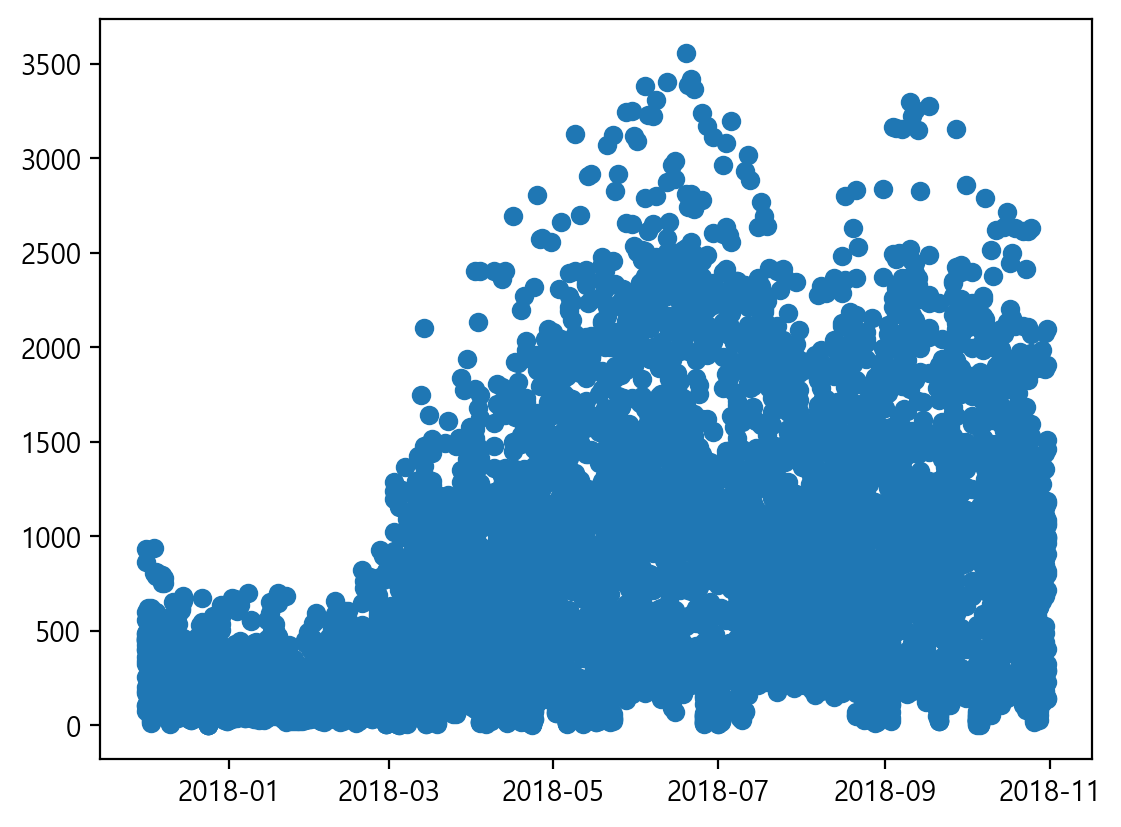

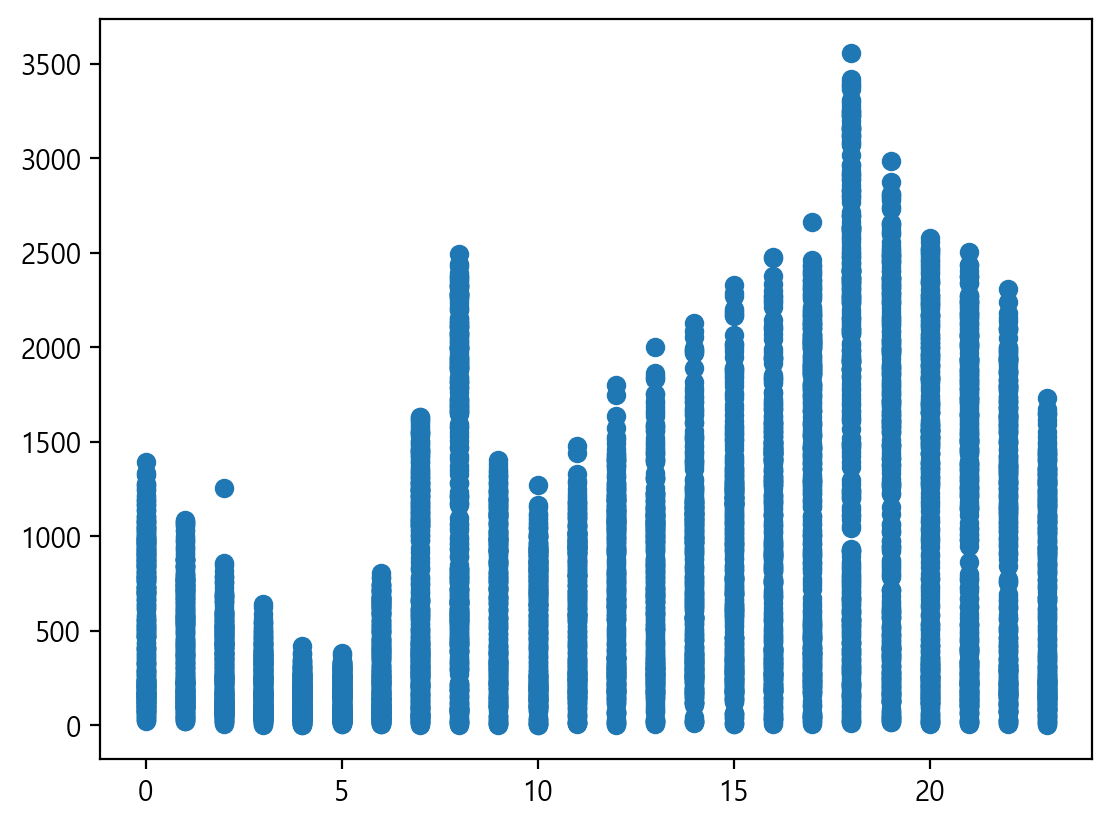

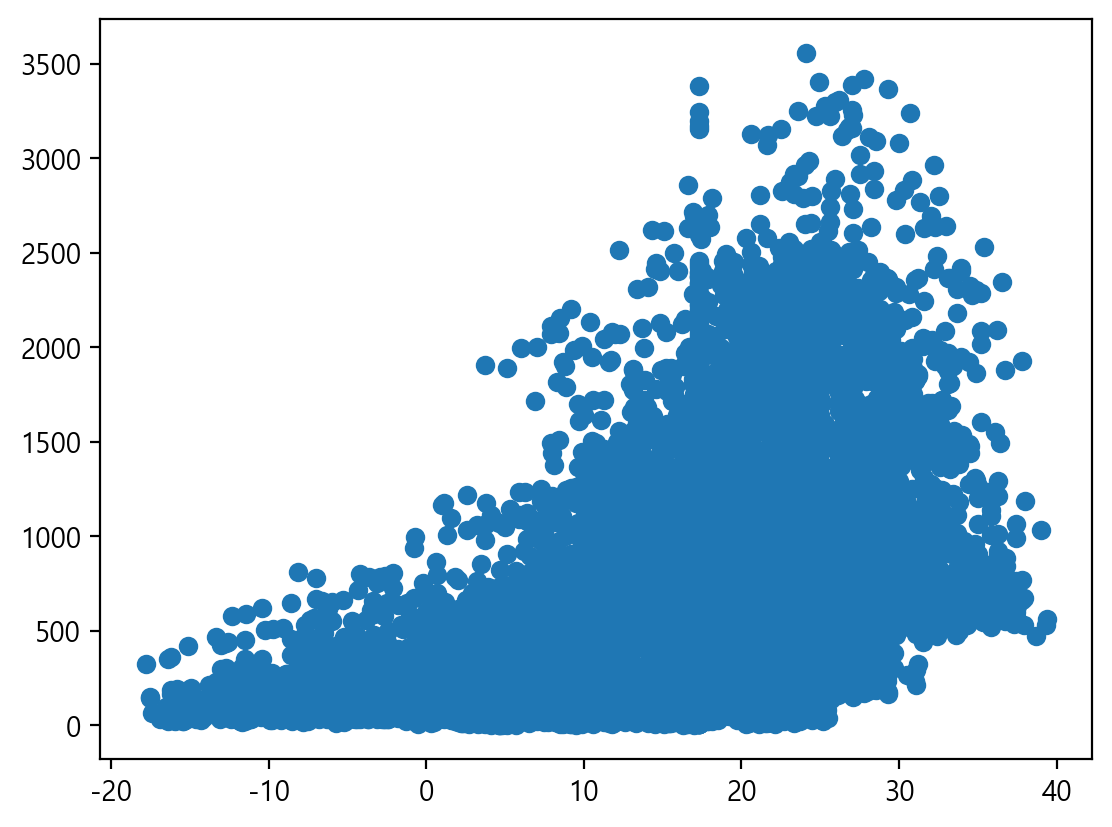

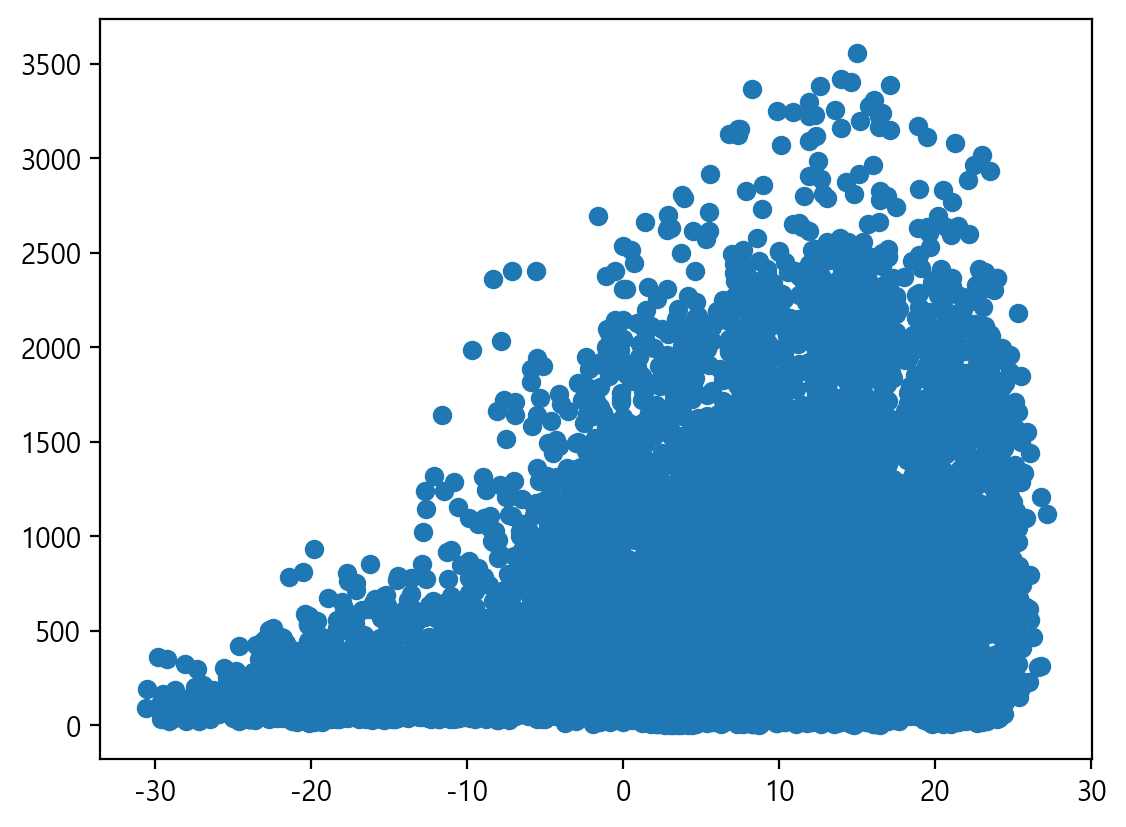

In [145]:
# 타겟값과 피처들의 관계에서 이상치가 발견되면 선형회귀 모델을 사용할 때 
# 정확도가 떨어질 수 있기 때문에 심하게 벗어나는 값이 있는지 확인해야 함

for i in ['날짜','시','온도','이슬점']:
    plt.scatter(new_df[i],new_df['대여횟수'])
    
    plt.show()
# 5가지의 피처에는 크게 이상치가 없는 것으로 보인다. 

<Axes: ylabel='Count'>

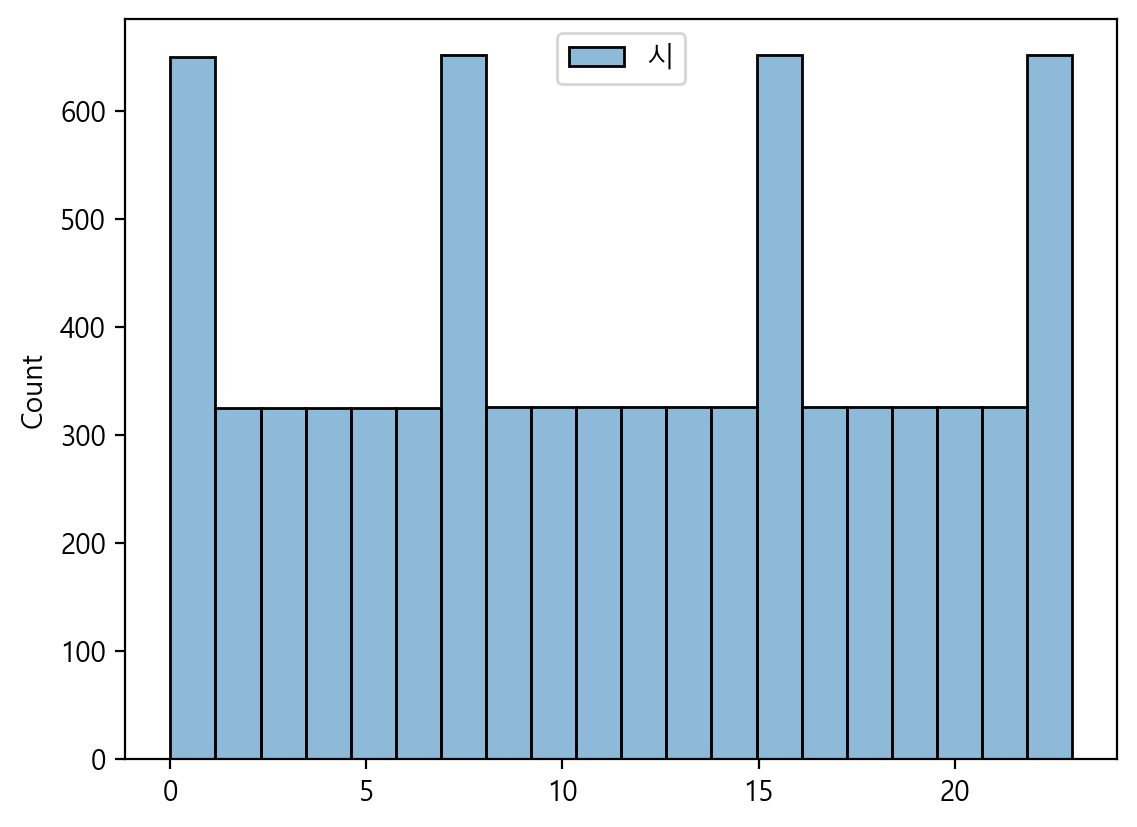

<Axes: ylabel='Count'>

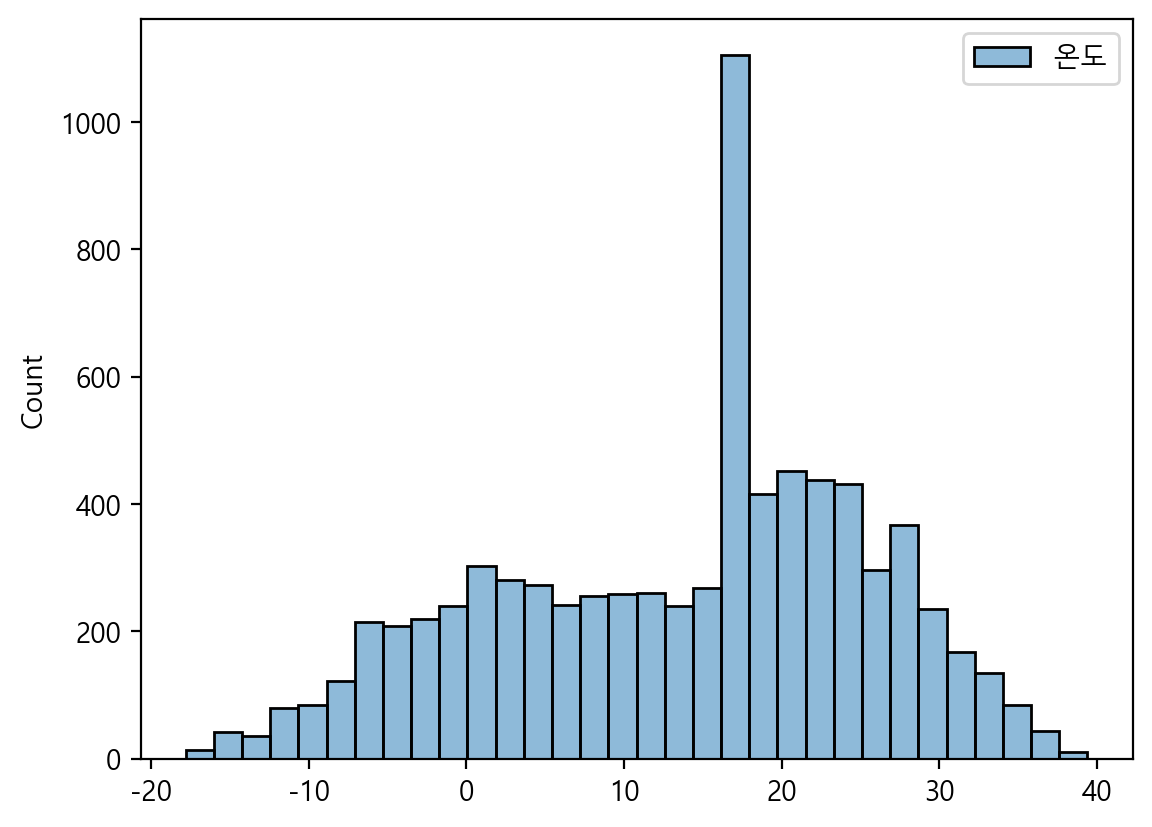

<Axes: ylabel='Count'>

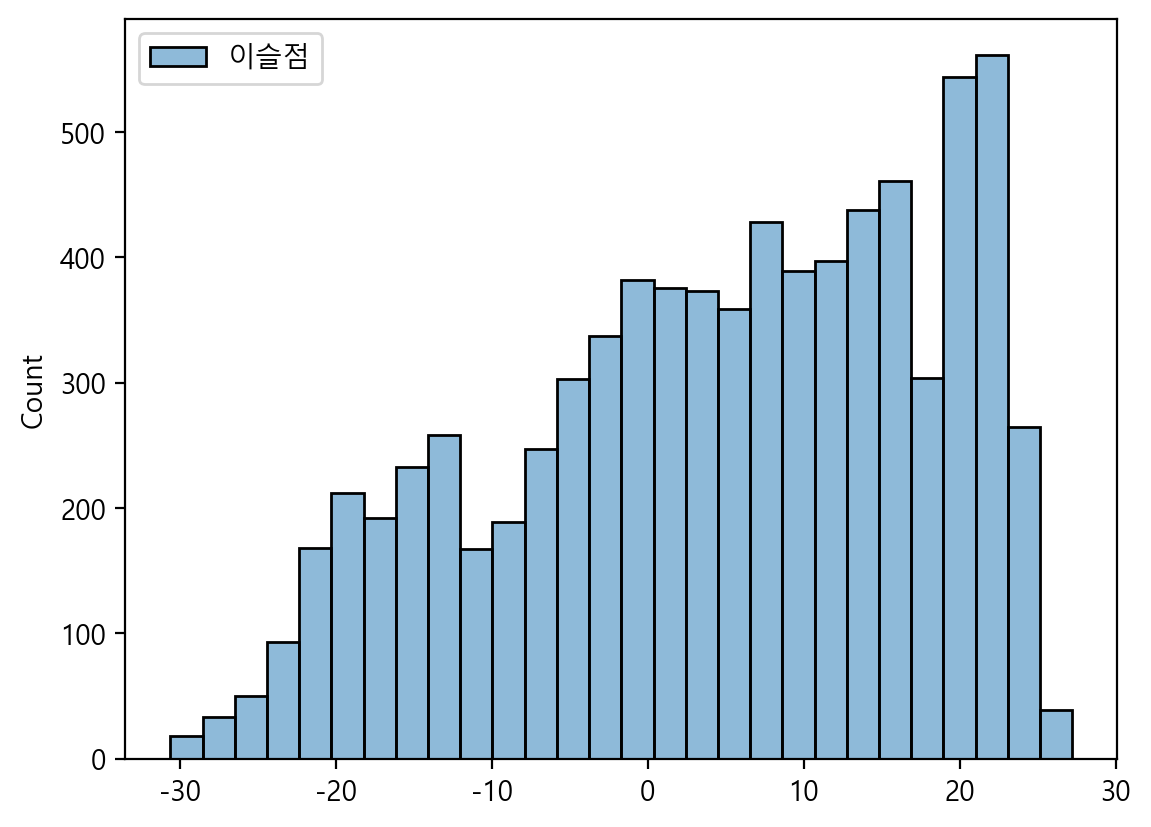

In [146]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
for i in ['시','온도','이슬점']:
    sns.histplot(new_df[[i]])
    plt.show()

## 범주형 데이터 수치화

In [147]:
x_df = train_data_del.select_dtypes(include=['object']).columns
new_df_ob = train_data_del[x_df]
new_df_ob.shape

(7817, 3)

In [148]:
new_df_ob.isna().sum()

계절       0
휴무일여부    0
작동여부     0
dtype: int64

In [149]:
#순서형 변수가 없기 때문에 get_dummies로 원핫 인코딩 수행
import numpy as np
# 계절 휴무여부 작동여부 모두 원핫 인코딩 변환 
new_df_ob['계절'].describe()
new_df_ob['휴무일여부'].describe()
new_df_ob['작동여부'].describe()

count       7817
unique         4
top       Winter
freq        2715
Name: 계절, dtype: object

count           7817
unique             2
top       No Holiday
freq            7409
Name: 휴무일여부, dtype: object

count     7817
unique       1
top        Yes
freq      7817
Name: 작동여부, dtype: object

In [150]:
weather_df=pd.get_dummies(new_df_ob['계절'],dtype=int,prefix="weather")
weather_df
holiday_df=pd.get_dummies(new_df_ob['휴무일여부'],dtype=int)
holiday_df
work_df=pd.get_dummies(new_df_ob['작동여부'],dtype=int,prefix="working")
work_df

,weather_Autumn,weather_Spring,weather_Summer,weather_Winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
8035,1,0,0,0
8036,0,0,0,1
8037,1,0,0,0
8038,1,0,0,0


,Holiday,No Holiday
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
8035,0,1
8036,0,1
8037,0,1
8038,0,1


,working_Yes
0,1
1,1
2,1
3,1
4,1
...,...
8035,1
8036,1
8037,1
8038,1


In [151]:
final_df= pd.concat((weather_df,holiday_df,work_df,train_data_del),axis=1)


In [152]:
final_df.isna().sum()
final_df.head()

weather_Autumn    0
weather_Spring    0
weather_Summer    0
weather_Winter    0
Holiday           0
No Holiday        0
working_Yes       0
날짜                0
대여횟수              0
시                 0
온도                0
습도                0
풍속                0
가시성               0
이슬점               0
태양 복사에너지          0
강수량               0
강설량               0
계절                0
휴무일여부             0
작동여부              0
dtype: int64

,weather_Autumn,weather_Spring,weather_Summer,weather_Winter,Holiday,No Holiday,working_Yes,날짜,대여횟수,시,...,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부
0,0,0,0,1,0,1,1,2017-12-01,254,0,...,37,2.200000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,0,0,0,1,0,1,1,2017-12-01,204,1,...,38,0.800000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,0,0,0,1,0,1,1,2017-12-01,173,2,...,39,1.000000,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,0,0,0,1,0,1,1,2017-12-01,107,3,...,40,0.900000,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,0,0,0,1,0,1,1,2017-12-01,78,4,...,36,1.599755,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## 변수 스케일링

#### 스케일링을 하는 이유
- linear regression model 이란
    - feature와 target을 활용해서 모델을 생성한다.
    - 실제 값과 모델 간의 오류값의 차이가 작을수록 좋은 모델이라고 할 수 있다. 
    - 즉, 데이터들을 계속 학습시키며 오류값(R^2)을 최소화 시키는 회귀계수를 찾아야 하는 것이 목표이다.
- 좋은 모델을 위해
    - target의 분포와 feature 분포의 범위를 통일시켜줌으로써 특정 데이터에 편향성을 갖는 것을 막는다.
    - 특히 target, feature 간의 상관관계가 큰 featrue들의 분포는 더욱 중요할 것이다. 
- 또한 선형 회귀모델은 
    - 데이터가 가우시안 분포(정규분포)를 띄고 있다고 가정하고 구현되어 있다. (선형성,독립성,등분산성,정규성)
    - train , test 데이터에 표준화를 적용하는 것이 모델 예측 향상에 중요하다.
- 그러므로 
    - target,feature들의 스케일링을 통해 분포의 범위를 맞추고 정규분포 형태로 변환시키려 노력해야 함

In [153]:
# 선형 회귀 계열의 로지스틱 회귀는
# 데이터의 분포에 따라
# 예측 성능에 영향을 받을 수 있으므로
# 먼저 정규 분포 형태의 표준 스케일링을 적용한 뒤
# 학습/테스트 데이터 세트로 분리 후 모델 적용
# 하지만 우리는 train, test 분리되어 있기 때문에 각각 data에 스케일링 해준다. 

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='대여횟수', ylabel='Count'>

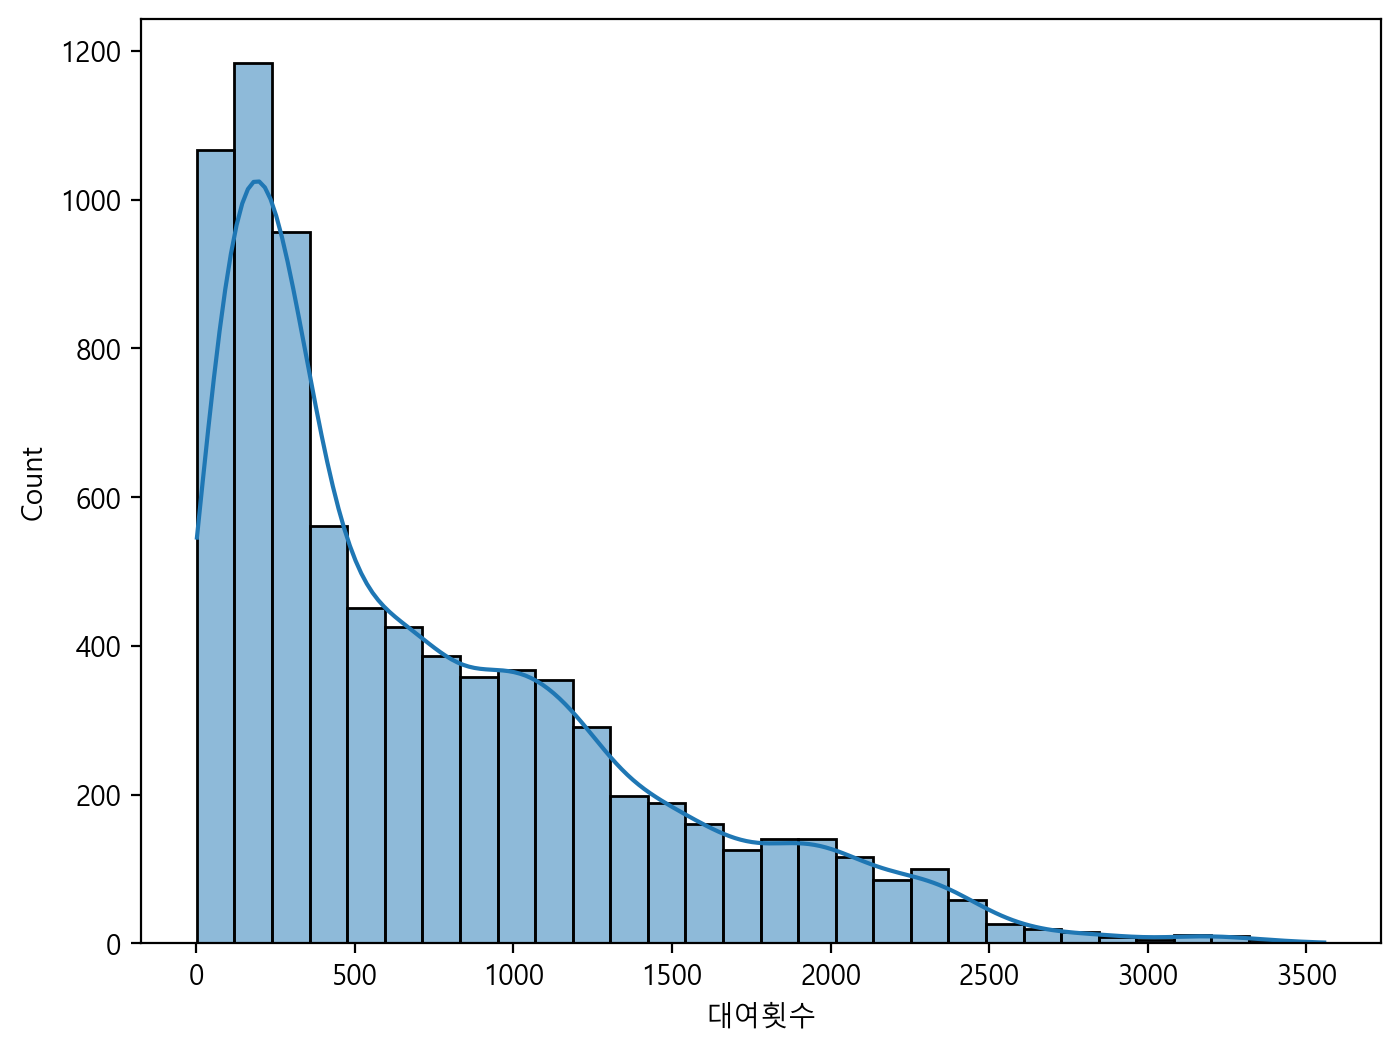

In [154]:
# 우선 target 값 즉 , 독립변수의 분포를 확인 후 정규분포 형태로 조정한다.
# 독립변수의 값 범위가 너무 넓게 되면 결과의 변수의 결과 값이 크게 달라질 수 있기 때문에 정규화 및 로그변환 실행해줌

plt.figure(figsize=(8, 6))
sns.histplot(final_df['대여횟수'], kde=True, bins=30)

<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

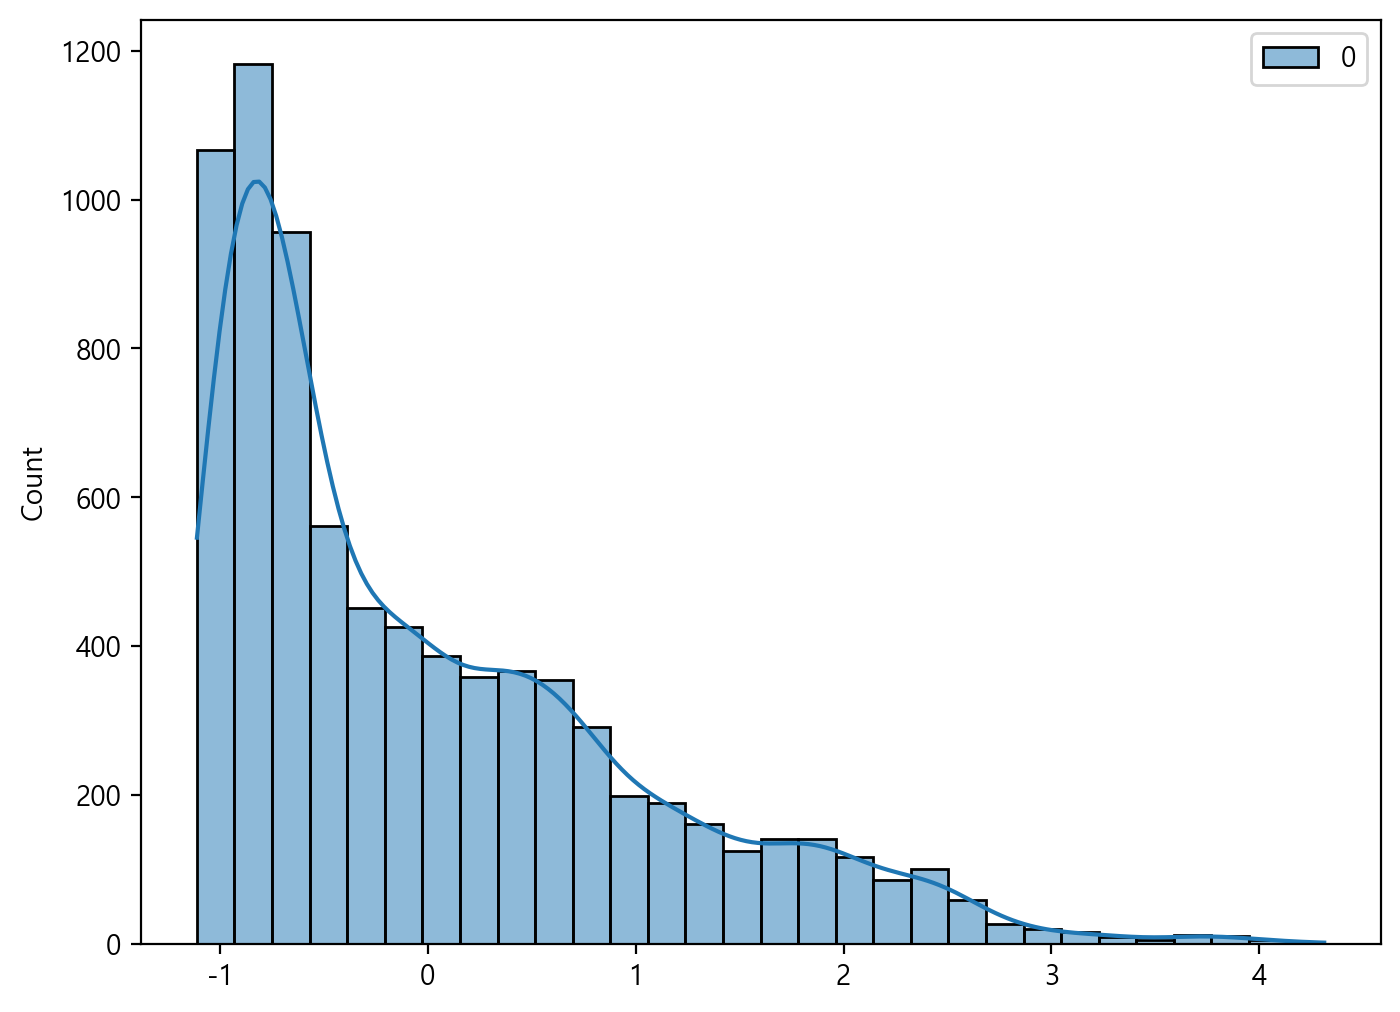

In [155]:
# 표준화
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaled_data = scaler.fit_transform(final_df[['대여횟수']])
plt.figure(figsize=(8, 6))
sns.histplot(scaled_data, kde=True, bins=30)

# 정규분포에 근사하지 않으므로 로그변환까지 해보겠다.


<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

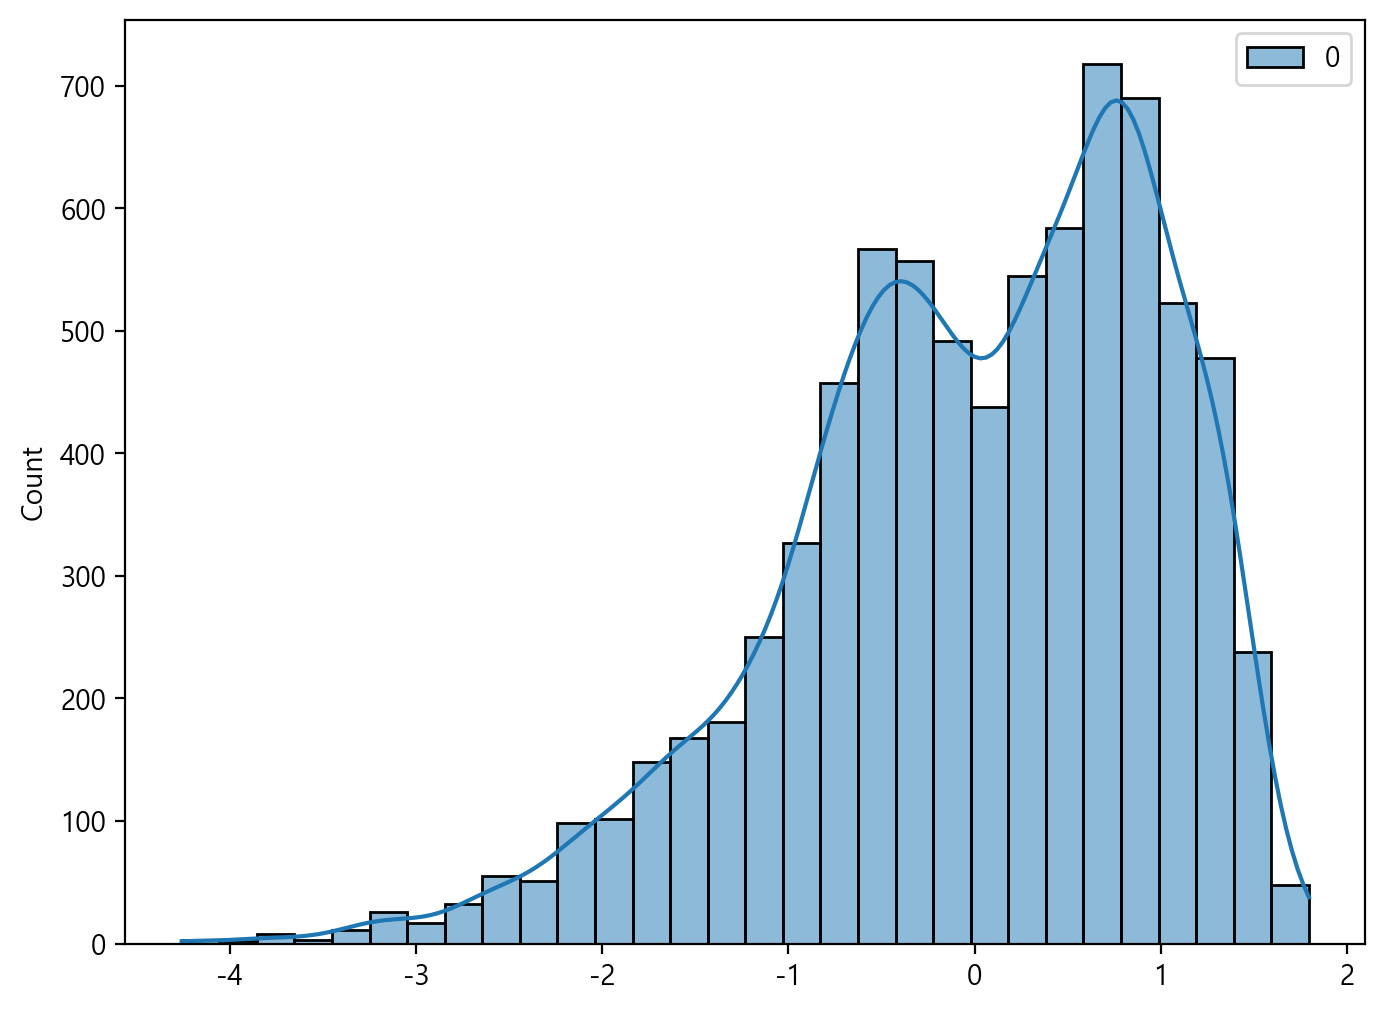

In [156]:
# 로그변환 후 표준화
lent_sc_log= scaler.fit_transform(np.log1p(final_df[['대여횟수']]))
plt.figure(figsize=(8, 6))
sns.histplot(lent_sc_log, kde=True, bins=30)

<Axes: ylabel='Count'>

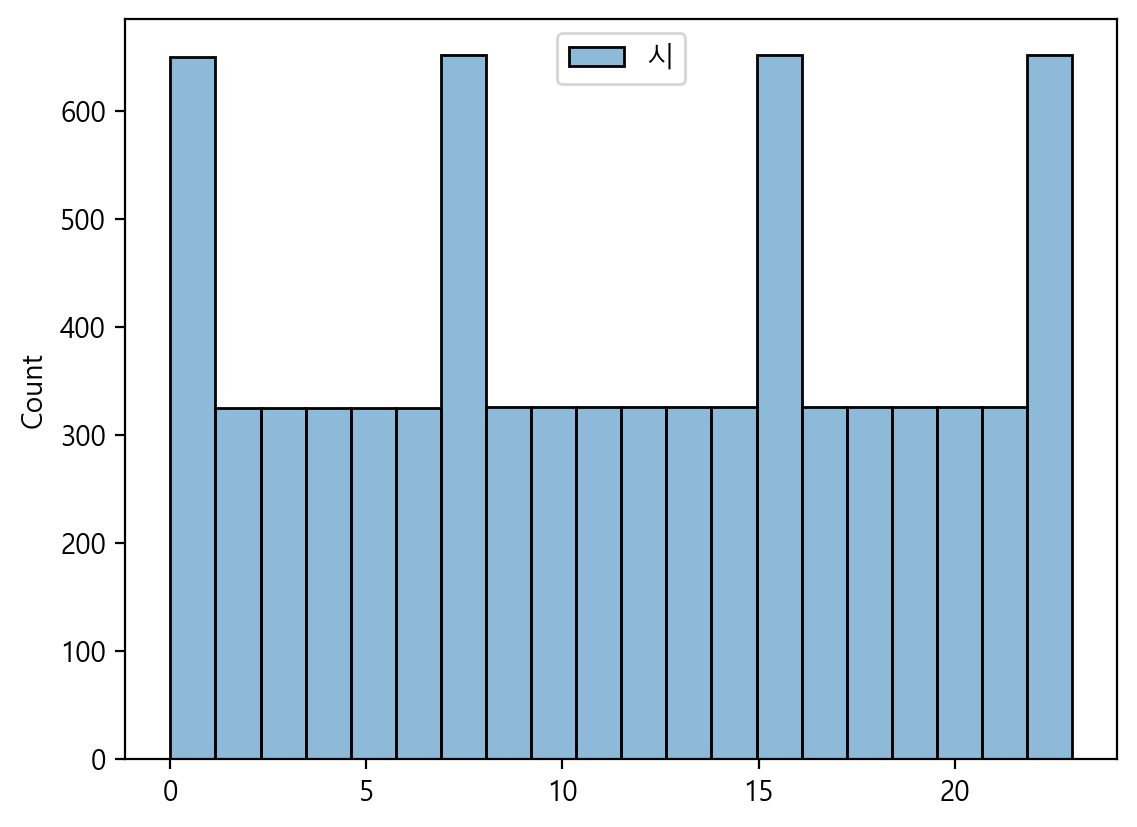

<Axes: ylabel='Count'>

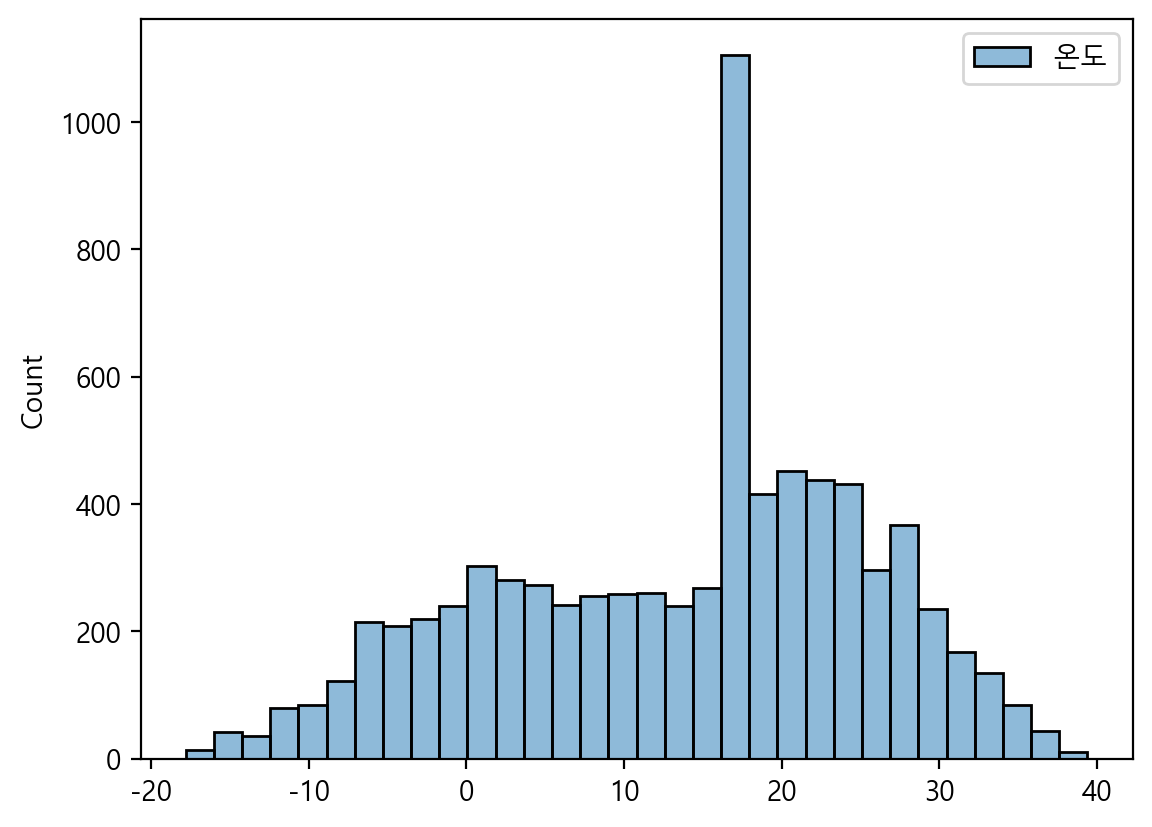

<Axes: ylabel='Count'>

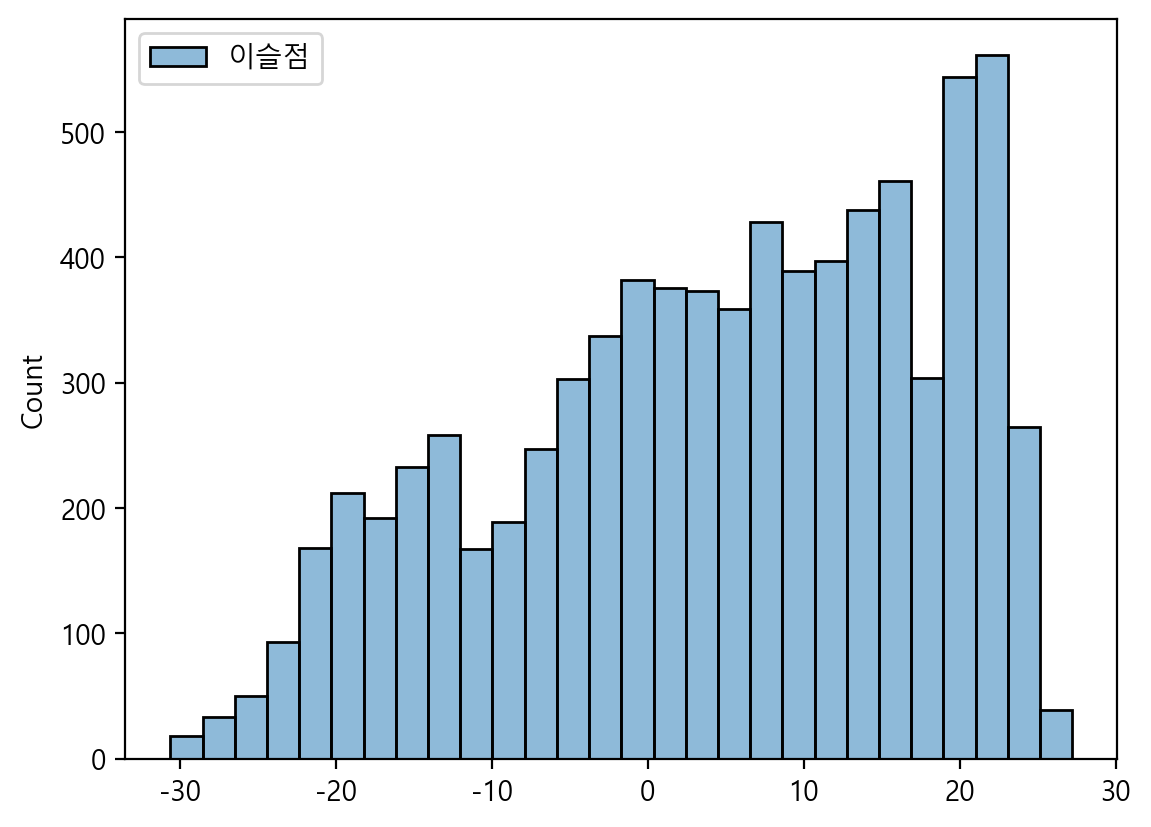

In [157]:
## 상관관계 높은 feature들
for i in ['시','온도','이슬점']:
    sns.histplot(final_df[[i]])
    plt.show()


<Axes: ylabel='Count'>

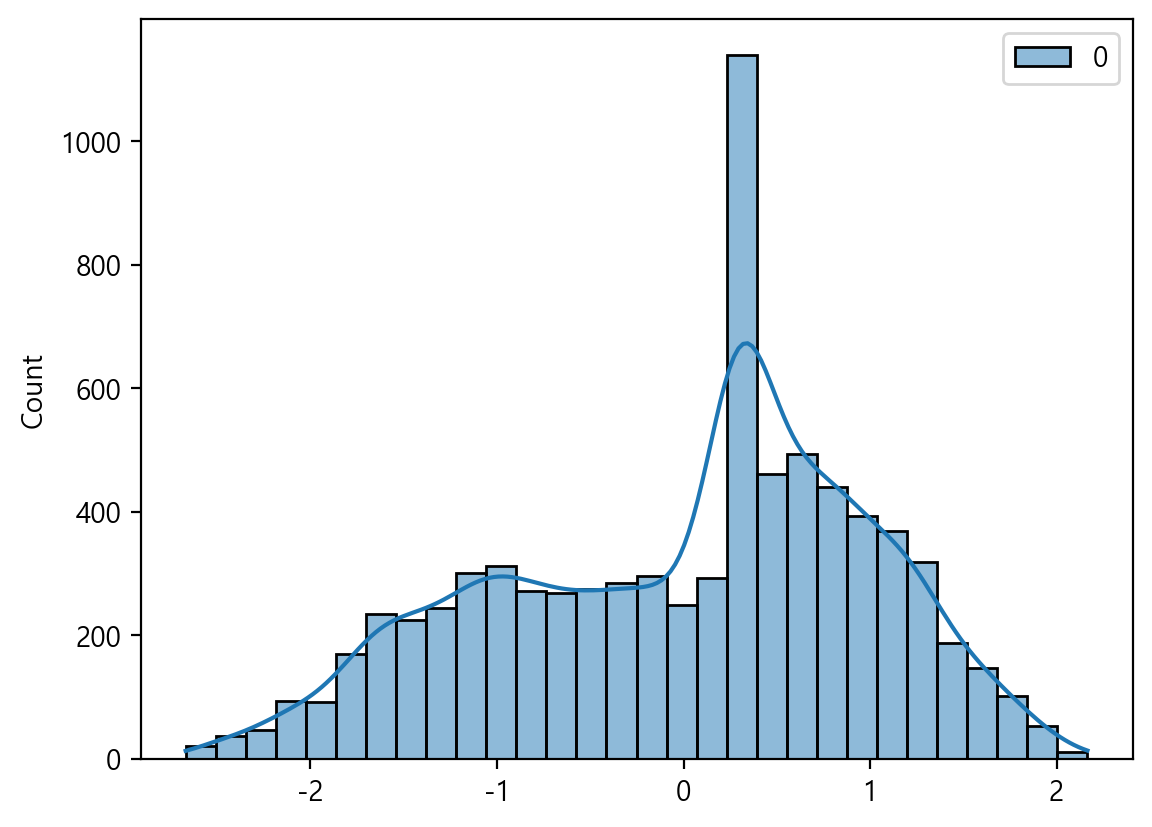

<Axes: ylabel='Count'>

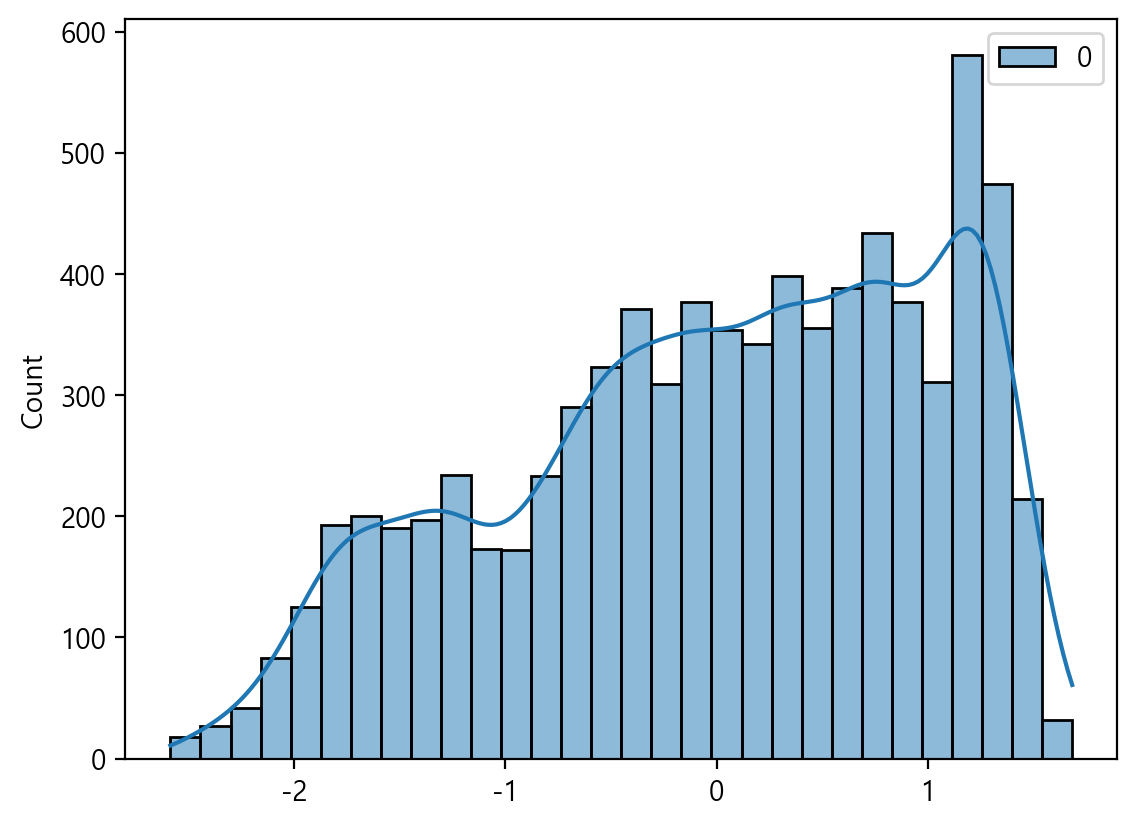

In [158]:
# 온도와 이슬점의 분포를 조정해보겠다. 
# 0보다 작은 값들이 있기 때문에 표준화만 실시 - > 범위를 맞춰줄 수 있다.
tem_sc_log= scaler.fit_transform(final_df[['온도']])
wa_sc_log= scaler.fit_transform(final_df[['이슬점']])
sns.histplot(tem_sc_log, kde=True, bins=30)
plt.show()
sns.histplot(wa_sc_log, kde=True, bins=30)

In [159]:
train_final_data= final_df.copy()
train_final_data['대여횟수']= scaler.fit_transform(np.log1p(final_df[['대여횟수']]))
train_final_data['온도']= scaler.fit_transform(final_df[['온도']])
train_final_data['이슬점']= scaler.fit_transform(final_df[['이슬점']])

## 최종 train_data/ test_data
- 결측치 처리
- 이상치 처리
- 범주형 데이터 처리
- 표준화

In [160]:
# 최종 train_data
train_final_data.head()

,weather_Autumn,weather_Spring,weather_Summer,weather_Winter,Holiday,No Holiday,working_Yes,날짜,대여횟수,시,...,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부
0,0,0,0,1,0,1,1,2017-12-01,-0.458385,0,...,37,2.200000,2000,-1.624695,0.0,0.0,0.0,Winter,No Holiday,Yes
1,0,0,0,1,0,1,1,2017-12-01,-0.645047,1,...,38,0.800000,2000,-1.624695,0.0,0.0,0.0,Winter,No Holiday,Yes
2,0,0,0,1,0,1,1,2017-12-01,-0.785270,2,...,39,1.000000,2000,-1.632079,0.0,0.0,0.0,Winter,No Holiday,Yes
3,0,0,0,1,0,1,1,2017-12-01,-1.193162,3,...,40,0.900000,2000,-1.624695,0.0,0.0,0.0,Winter,No Holiday,Yes
4,0,0,0,1,0,1,1,2017-12-01,-1.460586,4,...,36,1.599755,2000,-1.698531,0.0,0.0,0.0,Winter,No Holiday,Yes


In [161]:
# test_data 반복
test_data = pd.read_csv('../DATA/test.csv',encoding='cp949')
test_data.info()
# target 값이 없음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       720 non-null    object 
 1   Hour                       720 non-null    int64  
 2   Temperature(吏퇒)            644 non-null    float64
 3   Humidity(%)                720 non-null    int64  
 4   Wind speed (m/s)           646 non-null    float64
 5   Visibility (10m)           720 non-null    int64  
 6   Dew point temperature(吏퇒)  720 non-null    float64
 7   Solar Radiation (MJ/m2)    720 non-null    float64
 8   Rainfall(mm)               720 non-null    float64
 9   Snowfall (cm)              720 non-null    float64
 10  Seasons                    646 non-null    object 
 11  Holiday                    720 non-null    object 
 12  Functioning Day            720 non-null    object 
dtypes: float64(6), int64(3), object(4)
memory usage: 7

In [162]:
test_data.rename(columns={'Date':'날짜', 'Rented Bike Count':'대여횟수', 'Hour':'시', 'Temperature(吏퇒)':'온도', 'Humidity(%)':'습도',
       'Wind speed (m/s)':'풍속', 'Visibility (10m)':'가시성', 'Dew point temperature(吏퇒)':'이슬점',
       'Solar Radiation (MJ/m2)':'태양 복사에너지', 'Rainfall(mm)':'강수량', 'Snowfall (cm)':'강설량', 'Seasons':'계절',
       'Holiday':'휴무일여부', 'Functioning Day':'작동여부'}, inplace=True)


In [167]:
# 계절 전처리 
# 1. date 타입으로 날짜 형식 변환
test_data['날짜']=pd.to_datetime(test_data['날짜'], format='%d/%m/%Y')

# 2. 입춘 입하 입추 입동 기준으로 처리
# 날짜 구간 나누기
spring_df = (test_data['날짜'] >= '2018-02-04') & (test_data['날짜'] < '2018-05-05')
summer_df = (test_data['날짜'] >= '2018-05-05') & (test_data['날짜'] < '2018-08-07')
autumn_df = (train_data['날짜'] >= '2018-08-07') & (train_data['날짜'] < '2018-11-07')
winter_df= (test_data['날짜'] >= '2018-11-07') & (test_data['날짜'] < '2019-02-04')

# 조건문으로 빈 값 채우기
if (winter_df).any():
    test_data['계절'].fillna('Winter', inplace=True)
elif (spring_df).any():
    test_data['계절'].fillna('Spring', inplace=True)
elif (summer_df).any():
    test_data['계절'].fillna('Summer', inplace=True)
elif (autumn_df).any():
    test_data['계절'].fillna('Autumn', inplace=True)

In [168]:
# 온도 결측치 처리
# 계절 평균온도로 결측치 처리해주기 
df_tem=test_data.copy()
tem_season_df=pd.DataFrame(test_data.groupby(['계절'])['온도'].mean())
x=tem_season_df.values.flatten().tolist()
if (test_data['계절']=='Autumn').any():
    df_tem['온도'].fillna(round(x[0],2), inplace=True)
elif (test_data['계절']=='Spring').any():
    df_tem['온도'].fillna(round(x[1],2), inplace=True)
elif (test_data['계절']=='Summer').any():
    df_tem['온도'].fillna(round(x[2],2), inplace=True)
elif (test_data['계절']=='Winter').any():
    df_tem['온도'].fillna(round(x[3],2), inplace=True)

In [169]:
# 풍속 결측치 처리
imputer = IterativeImputer()
imputed_arr=imputer.fit_transform(test_data[['풍속', '태양 복사에너지', '시','습도']])
df_tem.풍속=pd.DataFrame(imputed_arr, columns=['풍속', '태양 복사에너지', '시','습도']).풍속

In [171]:
df_tem.isnull().sum()
test_data=df_tem

날짜          0
시           0
온도          0
습도          0
풍속          0
가시성         0
이슬점         0
태양 복사에너지    0
강수량         0
강설량         0
계절          0
휴무일여부       0
작동여부        0
dtype: int64

In [173]:
test_data

,날짜,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부
0,2018-11-01,0,5.7,62,2.300000,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes
1,2018-11-01,1,5.1,65,1.600000,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
2,2018-11-01,2,4.4,64,1.043358,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
3,2018-11-01,3,4.2,65,0.700000,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
4,2018-11-01,4,3.6,70,0.800000,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2018-11-30,19,4.2,34,2.600000,1894,-10.3,0.0,0.0,0.0,Winter,No Holiday,Yes
716,2018-11-30,20,3.4,37,2.300000,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
717,2018-11-30,21,2.6,39,0.300000,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
718,2018-11-30,22,2.1,41,1.000000,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [174]:
# 대여횟수가 없으므로 대여횟수 관련 행 처리 못함

In [176]:
# 범주형 수치화
x_df = test_data.select_dtypes(include=['object']).columns
new_df_ob = test_data[x_df]
new_df_ob.shape
weather_df=pd.get_dummies(new_df_ob['계절'],dtype=int,prefix="weather")
holiday_df=pd.get_dummies(new_df_ob['휴무일여부'],dtype=int)
work_df=pd.get_dummies(new_df_ob['작동여부'],dtype=int,prefix="working")

(720, 3)

In [179]:
final_df= pd.concat((weather_df,holiday_df,work_df,test_data),axis=1)
final_df.isna().sum()
final_df.shape

weather_Autumn    0
weather_Winter    0
No Holiday        0
working_No        0
working_Yes       0
날짜                0
시                 0
온도                0
습도                0
풍속                0
가시성               0
이슬점               0
태양 복사에너지          0
강수량               0
강설량               0
계절                0
휴무일여부             0
작동여부              0
dtype: int64

(720, 18)

In [180]:
# 표준화
test_final_data= final_df.copy()
test_final_data['온도']= scaler.fit_transform(final_df[['온도']])
test_final_data['이슬점']= scaler.fit_transform(final_df[['이슬점']])

In [181]:
test_final_data.head()

,weather_Autumn,weather_Winter,No Holiday,working_No,working_Yes,날짜,시,온도,습도,풍속,가시성,이슬점,태양 복사에너지,강수량,강설량,계절,휴무일여부,작동여부
0,1,0,1,0,1,2018-11-01,0,-0.467395,62,2.300000,1909,-0.009913,0.0,0.0,0.0,Autumn,No Holiday,Yes
1,1,0,1,0,1,2018-11-01,1,-0.606575,65,1.600000,1932,0.005019,0.0,0.0,0.0,Autumn,No Holiday,Yes
2,1,0,1,0,1,2018-11-01,2,-0.768952,64,1.043358,2000,-0.129365,0.0,0.0,0.0,Autumn,No Holiday,Yes
3,1,0,1,0,1,2018-11-01,3,-0.815346,65,0.700000,1962,-0.129365,0.0,0.0,0.0,Autumn,No Holiday,Yes
4,1,0,1,0,1,2018-11-01,4,-0.954526,70,0.800000,1934,-0.054707,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
test_final_data